In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv('/content/NFLX.csv')

In [3]:
df.head()
df.shape

(1009, 7)

In [4]:
df.isna().sum()

,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


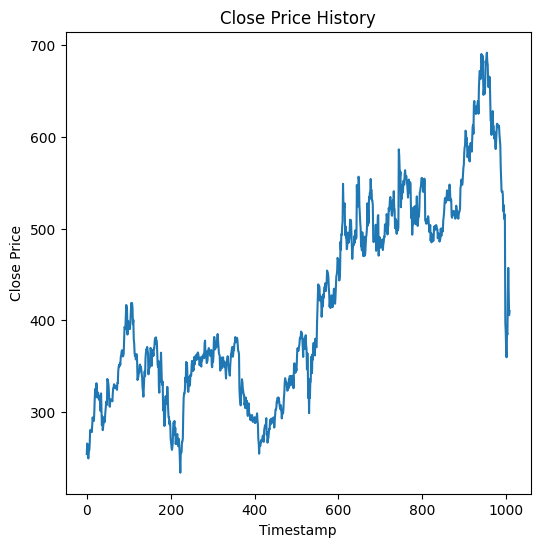

In [5]:
plt.figure(figsize=(6,6))
plt.title("Close Price History")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
sns.lineplot(df['Close'])
plt.show()

In [6]:
dataset=df.filter(['Close'])
data=dataset.values
train_data_len=math.ceil((len(data))*0.8)

In [7]:
scaler=MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(data)

In [8]:
train_data=data[0:train_data_len,:]
x_train=[]
y_train=[]
for i in range (60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [9]:
x_train,y_train=np.array(x_train),np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [10]:
model=Sequential()
model.add(LSTM(units=60,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=60,return_sequences=True))
model.add(LSTM(units=60,return_sequences=False))
model.add(Dense(units=60))
model.add(Dense(units=48))
model.add(Dense(units=48))
model.add(Dense(units=24))
model.add(Dense(units=24))
model.add(Dense(units=1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [12]:
early_stopping = EarlyStopping(monitor='loss', patience=5)
model.fit(x_train,y_train,batch_size=19,epochs=64, callbacks=[early_stopping])

Epoch 1/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 0.0287
Epoch 2/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0028
Epoch 3/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0029
Epoch 4/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0027
Epoch 5/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0025
Epoch 6/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0025
Epoch 7/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0027
Epoch 8/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0021
Epoch 9/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0016
Epoch 10/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0022
Epoch 11/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0022
Epoch 12/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0017
Epoch 13/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0018
Epoch 14/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0020
Epoch 15/64
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0015
E

In [13]:
test_data=data[train_data_len-60:]
x_test=[]
y_test=data[train_data_len:]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [14]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [15]:
prediction=model.predict(x_test)
prediction=scaler.inverse_transform(prediction)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


In [16]:
rmse=np.sqrt(np.mean(((prediction- y_test)**2)))
rmse

np.float64(564.96817173646)

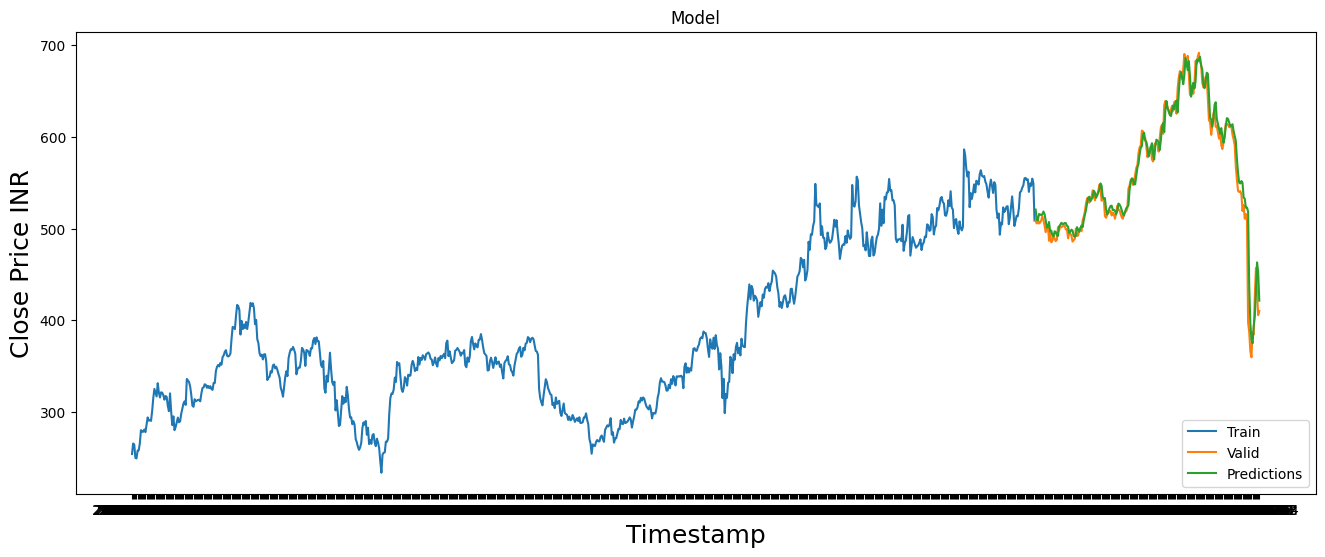

In [17]:
train = data[:train_data_len]
valid = data[train_data_len:]
valid_df = df[train_data_len:].copy()
valid_df['Close'] = scaler.inverse_transform(valid)
valid_df['Predictions'] = prediction
train_df = df[:train_data_len].copy()
train_df['Close'] = scaler.inverse_transform(train)
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Timestamp', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.plot(train_df['Date'], train_df['Close'])
plt.plot(valid_df['Date'], valid_df[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [18]:
model.save('netflix_stock_prediction_model.h5')